#LOADING LIBRARIES AND BUILDING PERMIT DATABASE IN SAN FRANCISCO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns #using it for heatmap and static figs

import warnings
warnings.filterwarnings('ignore')



In [2]:
pd.options.display.max_columns = None #The dataset is huge. To see all of the columns, we change max columns
pd.options.display.max_seq_items=1000
pd.options.display.max_rows=1000

In [3]:
db_v1= 'https://drive.google.com/file/d/1KdnyrBgasjIcO7wkgbqi0RST5igM1jNv/view?usp=sharing' #full dataset from datasf.org
db_v4 = 'https://drive.google.com/file/d/19ERs5bmAdxEfgUmTxgfIBhUoT6xPHzZy/view?usp=sharing' #refined dataset for new constructions
db_v8 = 'https://drive.google.com/file/d/1Ffbhy12m4JG9REEdSQwwewIFE0KUiEX3/view?usp=sharing' #dataset without outliers and new features added


#let's load the version 4 with all data
fname1 = db_v4
fname1='https://drive.google.com/uc?id=' + fname1.split('/')[-2]
dataset = pd.read_csv(fname1, low_memory=False)

#let's load the final version of database after outliers removed and with area per m2
fname2 = db_v8 
fname2='https://drive.google.com/uc?id=' + fname2.split('/')[-2]
dataset_v8 = pd.read_csv(fname2, low_memory=False)


In [4]:
dataset.shape

(9408, 42)

In [5]:
dataset.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number', 'Street Name',
       'Street Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Number of Proposed Stories',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Location',
       'Record ID', 'address', 'lat', 'lon', 'Duration_construction_days',
       'Process_time_days', 'Year', 'Est_Cost_Infl', 'Rev_Cost_Infl',
       'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge', 'lat_lon'],
      dtype='object')

#Columns in dataset

**Adress-related columns:**

       'Block', 'Lot', 'Street Number', 'Street Name',
       'Street Suffix', 'Neighborhoods - Analysis Boundaries', 'Zipcode,
       'Location',

       Added columns: 
       'address', 'lat', 'lon', 'lat_lon'

**Time-related columns:**

       'Current Status Date'
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 
       'Permit Expiration Date', 

        Added columns:
       'Duration_construction_days',
       'Process_time_days'

**Building type related columns:**

       'Permit Type', 'Permit Type Definition',
       'Description', 'Current Status',
       'Number of Proposed Stories',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Proposed Construction Type', 'Proposed Construction Type Description', 

**Cost related columns:**

       'Estimated Cost', 'Revised Cost',

       Added columns:
       'Est_Cost_Infl', 'Rev_Cost_Infl',
       'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge'

**SF ID-related columns:**

       'Permit Number', 
       'Site Permit', 'Supervisor District',
       'Record ID',

#Columns related to Dates and Duration

In the followings, we will convert Date columns to Datetime. It will be useful to avoid problems with our visualizations.

In [6]:
#selecting columns related to date
date_cols = [col for col in dataset.columns if 'date' in col.lower()]

*Let's check the earliest and latest dates ...*

In [7]:
for col in date_cols:
    dataset.loc[:,col] = pd.to_datetime(dataset[col], errors = 'coerce')
    print('Col :',col, ' Min= ', dataset.loc[:,col].min(), 'Max= ', dataset.loc[:,col].max())
    #we used errors = coerce, as there are some values/outliers out of the bound     

Col : Permit Creation Date  Min=  1977-10-19 00:00:00 Max=  2020-08-18 00:00:00
Col : Current Status Date  Min=  1982-01-25 00:00:00 Max=  2022-08-03 00:00:00
Col : Filed Date  Min=  1977-10-19 00:00:00 Max=  2020-08-18 00:00:00
Col : Issued Date  Min=  1978-06-13 00:00:00 Max=  2021-02-17 00:00:00
Col : Completed Date  Min=  1982-01-25 00:00:00 Max=  2022-08-03 00:00:00
Col : First Construction Document Date  Min=  1989-03-27 00:00:00 Max=  2022-06-16 00:00:00
Col : Permit Expiration Date  Min=  1980-10-29 00:00:00 Max=  2025-10-19 00:00:00


Here what we observe:

*   Permit creation records include data from 1977 to 2020.
*   Completed dates range from 1982 to 2022.



Most of the date columns are filled with the data. 

The figure by SF shows the stages of building permit:

![SFPlanning.org](data:image/png;base64,)
[ref-SFPlanning.org](https://sfplanning.org/project/pipeline-report#about)

It shows that

* Filed Dates represent the date when the city of San Francisco receives the building permit demand from the companies and indivuals.

* Issued Dates represent the date when the city of San Francisco makes a response whether the building permit is accepted or not. 

We use Completed Date and Issued Date to calculate the estimated duration of construction. It is an estimation.

We use Permit Creation Date to fill Year column. Then, we use Year column to integrate inflation rate of USD dollar in our cost data.

▶ **Let's investigate the distribution of Duration and Year columns further.**

In [8]:
def cat_stories (st): 
    """
    We create a column with categories of number of proposed stories
    """
    if st < 3 :
      y = '0-2 stories'
    elif st< 5 :
      y = '3-4 stories'
    elif st < 8 :
      y = '5-7 stories'
    elif st < 10 :
      y = '8-9 stories'
    else:
      y = 'More than 10 stories'
    return y

col_ ='Number of Proposed Stories'
dataset[col_].value_counts()
dataset[col_+'_cat'] = dataset[col_].apply(lambda x: cat_stories(x)).astype(str)

#We create a column of time spent in construction in years 
dataset['Duration_construction_years'] = dataset['Duration_construction_days']/365

print("\nHere is the amount of data in each category\n")
dataset['Number of Proposed Stories_cat'].value_counts()
#Let's graph them


Here is the amount of data in each category



3-4 stories             5001
0-2 stories             3458
More than 10 stories     462
5-7 stories              365
8-9 stories              122
Name: Number of Proposed Stories_cat, dtype: int64

**Let's analyze number of constructions completed by year** 

What is the year distribution of new constuctions in San Francisco?

In [9]:
fig = px.histogram (dataset.sort_values(by= 'Number of Proposed Stories_cat'), x='Completed Date',
                   title='Histogram of Completed Buildings in San Francisco',
                   opacity=0.8,
                   color='Number of Proposed Stories_cat',#"Permit Type Definition",
                   hover_data=['Number of Proposed Stories_cat']
                   )
fig.update_xaxes(rangeslider_visible=True,
                rangeselector=dict(
            buttons=list([
            #dict(count=1, label="1m", step="month", stepmode="backward"),
            #dict(count=6, label="6m", step="month", stepmode="backward"),
            #dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(count=20, label="20y", step="year", stepmode="backward"),
            dict(count=30, label="30y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
#fig.write_html("datevsnumberconstructions.html")
fig.show()

**Results:**

We observe that
1.   City of San Francisco had a very active construction market up to early 90s.

2.   Since 2004, there were fewer new construction projects in San Francisco. It is likely due to the lack of empty spaces, urban planning limits and recessions of 2001 and 2007 in the US economy. 

**Discussion:**

Tall buildings (10+ stories) were mostly built before 90s. Then there were very few tall building projects. It may be explained by the impact of the big San Francisco earthquake in 1989. It may have led both changes in building codes and demotivated the construction of tall buildings. Some other tall buildings were built after 2008 probably with the presence of giant tech companies being more common in the region.

More information on SF contruction trends can be found on the report: [https://sfplanning.org/project/san-francisco-housing-needs-and-trends-report]

**Idea(s):**

Can we predict the trend of construction market in the near future in San Francisco? This could be a subject of a further study.


In [10]:
#Graph 1 - Construction Duration Histogram
#Question: What is the duration of constructions? What parameters seem to affect it?

fig = px.histogram (dataset.sort_values(by = 'Number of Proposed Stories_cat'), x='Duration_construction_years',
                   title='Histogram of Construction Durations in San Francisco',
                   opacity=0.8,
                   marginal="box", 
                   color= 'Number of Proposed Stories_cat',
                   hover_data=dataset.columns,
                   range_x=[0, 10]
                   )

fig.update_xaxes(rangeslider_visible=False, title = 'Duration of construction in years')
fig.show()

**Results:**

We observe that
1.   Most of the constructed buildings have 0 - 4 stories.
2.   To build 0-2 stories take approximately between *0.5 and 1.5 years*.  
3.   To build 3-4 stories take approximately between *1.0 and 2.0 years*. 
4.   To build 5-7 stories take approximately between *1.5 and 3.5 years*.
5.   To build 8-9 stories take approximately between *2.0 and 4.0 years*.
5.   To build tall buildings take approximately between *1.0 and 3.5 years*.

**Discussion:**

There are cases where the construction can take much larger than these central values.

What would be the reasons of these long construction delays? There can be unexpected delays in an ongoing construction due to late material delivery, financial problems, natural disasters like earthquakes, etc... Also, construction companies may have chosen to start their projects years after their permit being issued.

By rule of thumb, we can expect taller buildings take much longer time to construct than buildings with fewer stories. This trend is pretty much observed except the buildings with more than 10 floors. It can be due to not having equivalent amount of data in each category. 

**Idea(s):**

Let's see the importance of construction duration later in ML part.  


#Columns related to Location

In [11]:
#Let's map all construction projects in a map
dataset['Estimated cost in today s dollars in log10']=dataset['Est_Cost_Infl_log10'].astype(int)


lat0 , lon0 = 37.750000, -122.431000
fig = px.scatter_mapbox(dataset, lat="lon", lon="lat",
                        zoom = 11.0, center = {'lat': lat0, 'lon': lon0}, 
                        mapbox_style="stamen-toner", color='Estimated cost in today s dollars in log10',
                        title = 'Locations of buildings constructed in San Francisco since early 80s ',                 
              )

fig.show()
#fig.write_html("map_construction.html")



*   Buildings in downtown and financial district area are composed of mostly high rise buildings and the demand is much higher in the central location. That can explain the cost of the projects in the central areas .

**Let's graph data grouped by neighborhoods below.**



In [12]:
#Let's create a new dataframe representing characteristic values of each neighborhood
neigh_ = 'Neighborhoods - Analysis Boundaries'

#First, we need to create few other columns for readability
dataset['Cost_1M'] = dataset['Est_Cost_Infl']/1000000 # estimated cost in today's 1M dollar
dataset['Completed Year'] = dataset['Completed Date'].dt.year #year of project completion

#Let's provide following informations on map : 
# ----- average of construction cost, avg completed year, avg numnber of stories, total project counts 
cols_ = ['Cost_1M','Completed Year','Number of Proposed Stories','lat','lon']

##taking averages by neighborhood:
#note that coordinates of neighborhoods are obtained by mean lat and lon
table_locn = (dataset.groupby(neigh_)[cols_]).mean() 

#keeping total project counts:
table_locn ['count'] =  dataset.groupby(neigh_).count().iloc[:,0]

#seperate column with neigborhood names and removing 'other' column
table_locn['Neighborhoods']=table_locn.index
m1 = table_locn['Neighborhoods'] != 'Other'
table_locn= table_locn.loc [m1,:]

#reseting index. it is neccessary to be able to see hover information
table_locn = table_locn.reset_index(drop=True)

#changing column names for readability
table_locn.columns = ['Median cost in 1M$', 'Median completed year', 'Median # of stories', 
                      'lat', 'lon', 'Total counts', 'Neighborhoods']

#rounding float numbers for readability of values
cols_num = ['Median cost in 1M$', 'Median completed year', 'Median # of stories']
table_locn [cols_num] = table_locn [cols_num].round(2)

In [13]:
lat0 , lon0 = 37.750000, -122.431000
fig = px.scatter_mapbox(table_locn, lat="lon", lon="lat",
                        zoom = 11.0, center = {'lat': lat0, 'lon': lon0}, 
                        mapbox_style="carto-positron", color='Total counts',
                        size= 'Median cost in 1M$',size_max = 70,
                        title = 'New buildings constructed in San Francisco since early 80s by log cost ',
                        hover_name = 'Neighborhoods',
                        hover_data = {'Total counts': True,
                                      'Median cost in 1M$':True,
                                      'Median completed year':True,
                                      'Median # of stories':True,
                                      'lon' : False,
                                      'lat' : False,
                                      'Neighborhoods': False}                     
)

fig.update_layout( hovermode="closest")
fig.show()
#fig.write_html("neigh_construction.html")


**Results:**

We observe that

1.   Number of stories built is correlated to the estimated project cost.

2.   High rise buildings took mostly in the vicinity of downtown San Francisco (Financial D/South B, Tenderloin, Mission Bay, Chinatown and South of Market). So, we can also see that most expensive construction projects mostly took place in the vicinity of downtown SF.  

3.   Housing projects with fewer stories took place away from the city center. 

4.   Most of the  new construction projects took place in Bayview Hunters Point. Also, regions like Mission, Portero Hill and Outer Richmond had active construction efforts. These neighborhoods are located away from the city center. The urban planning strategy has been likely on the fact of expanding new constructions away from the city center. It is likely that it also provided more affordable housing in the time of very high housing prices in San Francisco.


**Idea(s):**

**Let's find top five neigborhoods with most expensive construction projects and most construction project amounts 🥽**

In [14]:
print('\nTop 5 neighborhoods with highest median construction cost')
table_locn.sort_values(by = 'Median cost in 1M$',ascending = False).iloc[:,[-1,0,-2]].head(5)


Top 5 neighborhoods with highest median construction cost


Neighborhoods  Median cost in 1M$  Total counts
5   Financial District/South Beach               52.91           180
30                      Tenderloin               40.91            57
15                     Mission Bay               39.18           118
3                        Chinatown               31.75            34
28                 South of Market               13.71           320

In [15]:
print('\nTop 5 neighborhoods with most active new construction activities since 80s\n')
table_locn.sort_values(by = 'Total counts',ascending = False).iloc[:,[-1,-2]].head(5)


Top 5 neighborhoods with most active new construction activities since 80s



Neighborhoods  Total counts
0   Bayview Hunters Point          1543
14                Mission           490
24           Potrero Hill           454
21         Outer Richmond           420
28        South of Market           320

***Let's see if there is a trend on which year on which neighborhood***

#Columns related to Cost

In [16]:
print('\nMedian cost of construction projects in million $ by number of stories')
dataset.loc[:,['Number of Proposed Stories_cat','Est_Cost_Infl']].groupby(by='Number of Proposed Stories_cat').median()/1000000.


Median cost of construction projects in million $ by number of stories


Est_Cost_Infl
Number of Proposed Stories_cat               
0-2 stories                          0.349639
3-4 stories                          0.621966
5-7 stories                         10.805552
8-9 stories                         20.093476
More than 10 stories                 2.607665

In [17]:
print('\nMedian cost of construction projects by permit type')
print("""
    Type 1: 'New Construction (Reinforced concrete, Steel, etc...)' Type 2: 'New Construction Wood Frame'
    """)
dataset.loc[:,['Permit Type','Est_Cost_Infl']].groupby(by='Permit Type').median()/1000000.



Median cost of construction projects by permit type

    Type 1: 'New Construction (Reinforced concrete, Steel, etc...)' Type 2: 'New Construction Wood Frame'
    


Est_Cost_Infl
Permit Type               
1                 8.356686
2                 0.498718

In [18]:
print('\nMedian cost of construction projects by construction type')
print("""
    Type 1: 'Ordinary', Type 2: 'Fire resistive', Type 3: 'Combustible', Type 4: 'Heavy Timber', 
    Type 5: 'Wood-framed', Type 99 :'Other
""")
dataset.loc[:,['Proposed Construction Type','Est_Cost_Infl']].groupby(by='Proposed Construction Type').median()/1000000.



Median cost of construction projects by construction type

    Type 1: 'Ordinary', Type 2: 'Fire resistive', Type 3: 'Combustible', Type 4: 'Heavy Timber', 
    Type 5: 'Wood-framed', Type 99 :'Other



Est_Cost_Infl
Proposed Construction Type               
1                               22.185573
2                                2.613749
3                                1.134097
4                                0.809373
5                                0.495690
99                               0.909791

In [19]:
print('\nMedian cost of construction projects by construction purposes\n')
table_pu = dataset.loc[:,['Proposed Use','Est_Cost_Infl']].groupby(by='Proposed Use')
table_pu = pd.concat([table_pu.count(), table_pu.median()/1000000.],axis=1)
table_pu.columns = ['Count','Median in 1 Million $']
table_pu.sort_values(by = 'Count',ascending= False).head(5)



Median cost of construction projects by construction purposes



Count  Median in 1 Million $
Proposed Use                                   
1 family dwelling   3140               0.316237
apartments          2606               1.268823
2 family dwelling   1916               0.550752
office               211               7.631004
artist live/work     201               1.066811

Results:

We observe that

* Number of stories built is correlated to the estimated project cost. There is a project cost jump from 4-story buildings to more than 5-story buildings. We do not have sufficient data for buildings above 15 floors.

* Permit type is correlated to the estimated project cost. It costs much less with wood-framed structures.

* Construction type is correlated to the estimated project cost. 'Ordinary' type costs most than others. 

* Proposed use is correlated to the estimated project cost. Appartments cost much more than 1- and 2- family dwellings. We don't have equivalent amount of data for other types of use

**Conclusions**


1.   Let's keep number of stories, permit type, construction type and proposed use as a feature for our machine learning model.
2.   We need to limit our predictions to the presence of data in categories. It is a good idea to limit prediction model 
    
      * Up to 15-story buildings and 
      * Use of 1-, 2-family dwellings and appartments




In [20]:
print("Let's take the version 8 of database with area per m2 column added and outliers cleaned.")
print("")
print("It includes appartments, 1-/2- family dwellings and appartments up to 15 floors.")
#dataset_v8

Let's take the version 8 of database with area per m2 column added and outliers cleaned.

It includes appartments, 1-/2- family dwellings and appartments up to 15 floors.


Estimated cost versus revised cost in today's $



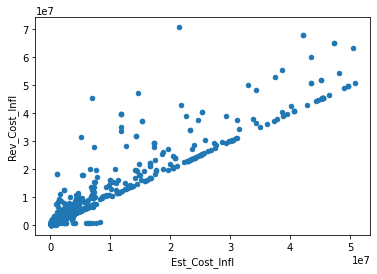

In [21]:
print("Estimated cost versus revised cost in today's $\n")
dataset_v8.plot.scatter(y='Rev_Cost_Infl',x='Est_Cost_Infl')


Boxplot of ratio of revised cost and estimated cost




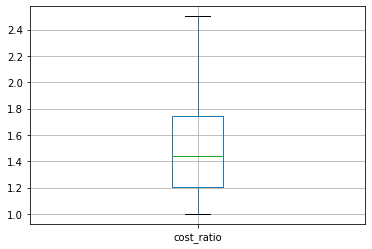

In [22]:
#let's find out the trend between revised cost and proposed cost
print('\nBoxplot of ratio of revised cost and estimated cost\n\n')
dataset_v8['cost_ratio'] = dataset_v8['Rev_Cost_Infl']/dataset_v8['Est_Cost_Infl']
m1 = dataset_v8['cost_ratio'] >dataset_v8['cost_ratio'].quantile(0.05) #possible outliers lower cap
m2 = dataset_v8['cost_ratio'] <dataset_v8['cost_ratio'].quantile(0.95) #possible outlier lower cap
dataset_v8.loc[m1&m2,:].boxplot(['cost_ratio'])

In [23]:
print('\nStatistics of ratio of revised cost and estimated cost\n')
dataset_v8.loc[m1&m2,'cost_ratio'].describe()


Statistics of ratio of revised cost and estimated cost



count    2479.000000
mean        1.508934
std         0.354496
min         1.000000
25%         1.207333
50%         1.440000
75%         1.741071
max         2.500000
Name: cost_ratio, dtype: float64

**Observation**



*   Mean ratio of revised cost and estimated cost is about 1.5. 

**Idea(s)**

Let's include this ratio in the cost of construction project predicted at the end



In [24]:
print("Let's dive into the distrubtion of estimated project cost per m2\n")
m1 = dataset_v8['cost_per_m2'] >dataset_v8['cost_per_m2'].quantile(0.10)
m2 = dataset_v8['cost_per_m2'] <dataset_v8['cost_per_m2'].quantile(0.90)

cost_ratio= 1.5 #average ratio of revised cost and estimated cost 

med_costperm2 = dataset_v8.loc[m1&m2,['cost_per_m2','Year']].groupby(by='Year').median() * cost_ratio
med_costperm2['Year']= med_costperm2.index
med_costperm2 ['cost_per_ft2'] = med_costperm2 ['cost_per_m2']/10.764 #conversion to ft sq
#print("Graph of construction cost per m2 per year\n")

#fig = px.line(med_costperm2, y='cost_per_m2', x='Year',markers=True)
#fig.update_yaxes(title = "Median construction cost per m2 ($)")
#fig.show()

Let's dive into the distrubtion of estimated project cost per m2



In [25]:
print("Graph of construction cost per feet2 per year\n")
print("It includes data only for buildings up to 15 stories for residential use.\n")
fig = px.line(med_costperm2, y='cost_per_ft2', x='Year',markers=True)
fig.update_yaxes(title = "Median construction cost ($)")
fig.show()


Graph of construction cost per feet2 per year

It includes data only for buildings up to 15 stories for residential use.



In [26]:
m3 = dataset_v8['Year'] >2015 #masking data for the last five years
cost_ratio= 1.5 #average ratio of revised cost and estimated cost 

val_m2 = dataset_v8.loc[m1&m2&m3,['cost_per_m2']].median() * cost_ratio
val_m2 = int(val_m2[0])
val_ft2 = int(val_m2/10.764)

print(f'\nMedian construction cost for residentials up to 15 stories since 2015:\n   {val_m2} $ per meter square \n    {val_ft2} $ per feet square\n')


Median construction cost for residentials up to 15 stories since 2015:
   3285 $ per meter square 
    305 $ per feet square



**Discussion**

The median construction cost has been increasing since 2015, where we calculate a median construction cost per square feet of 305$.

Even though the construction cost here is not directly comparable, in a recent study, the average construction cost per square foot is 250 -- 400$ for San Francisco Bay Area. 

Reference to Terner Center report: [https://ternercenter.berkeley.edu/research-and-policy/hard-construction-costs-apartments-california/]


#***Let's explore heatmap***

In [27]:
print("We will use version 8 of database with area per m2 column added and outliers cleaned here.")
print("")
print("It includes appartments, 1-/2- family dwellings and appartments up to 15 floors.")
#dataset_v8

We will use version 8 of database with area per m2 column added and outliers cleaned here.

It includes appartments, 1-/2- family dwellings and appartments up to 15 floors.


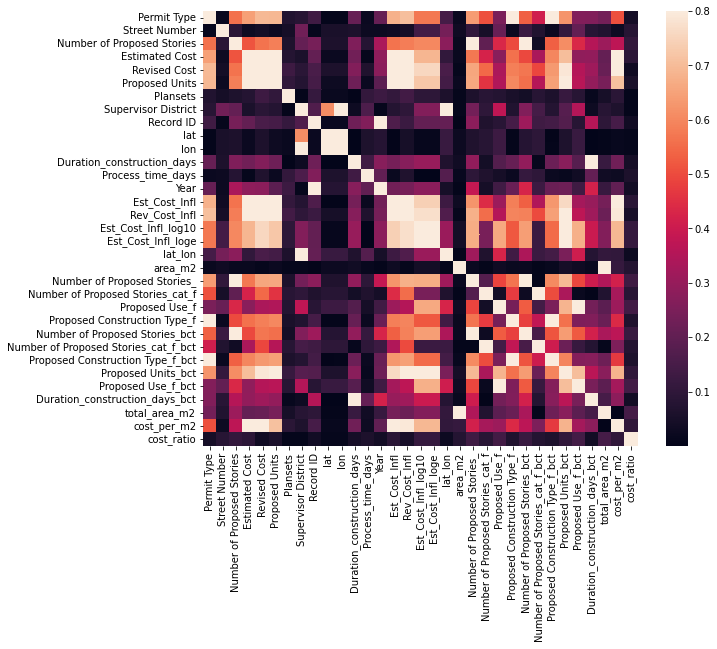

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset_v8.corr().abs(), vmax=.8, square=True)
#fig.savefig('drive/MyDrive/colab/data_heatmap.jpg',dpi=400)

**Results:**

We observe that estimated cost is in correlation with certain columns.

**Let's dive into these columns as well as the categorical columns **

In [29]:
hcols_num = ['Permit Type',
       'Number of Proposed Stories',
       'Estimated Cost', 'Revised Cost',
        'Proposed Units', 'Plansets',
       'Proposed Construction Type', 
       'Supervisor District',
        'Location',
       'Duration_construction_days',
       'Year',
        'Est_Cost_Infl', 'Rev_Cost_Infl',
       'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge', 
       'lat','lon', 'lat_lon','Zipcode',
        'area_m2',
       'total_area_m2', 'cost_per_m2']
       
hcols_cat = ['Proposed Use', 
              'Proposed Construction Type Description',
       'Description', 
       'Permit Type Definition',
        'Neighborhoods - Analysis Boundaries', 'Zipcode',
        'Number of Proposed Stories_cat'
       ]

In [30]:
newdf = dataset_v8[hcols_num]
newdf_cat = dataset_v8[hcols_cat]

In [31]:
print("\n[Numeric columns] Driving parameters of construction cost. The closer the value is to 1.0, the more the correlation is.\n")
newdf.corr().loc[:,['Est_Cost_Infl_log10','Est_Cost_Infl']].abs().sort_values(by='Est_Cost_Infl_log10',ascending=False)


[Numeric columns] Driving parameters of construction cost. The closer the value is to 1.0, the more the correlation is.



Est_Cost_Infl_log10  Est_Cost_Infl
Est_Cost_Infl_log10                    1.000000       0.740890
Est_Cost_Infl_loge                     1.000000       0.740890
Rev_Cost_Infl                          0.773270       0.950794
Revised Cost                           0.758476       0.960960
Est_Cost_Infl                          0.740890       1.000000
Proposed Units                         0.723331       0.873405
cost_per_m2                            0.691061       0.808902
Estimated Cost                         0.688520       0.979253
Number of Proposed Stories             0.602591       0.562830
Permit Type                            0.573021       0.680219
lat_lon                                0.309220       0.131046
Duration_construction_days             0.302256       0.240719
Year                                   0.279069       0.231823
total_area_m2                          0.263338       0.239126
Supervisor District                    0.262749       0.075392
Plansets                               0.096109       0.108435
area_m2                                0.043613       0.029656
lat                                    0.013558       0.005512
lon                                    0.013366       0.005331

In [32]:
#First, we apply pd.factorize to encode categorical variables.
newdf_cat = newdf_cat.apply(lambda x : pd.factorize(x)[0])

#Second, we include cost related columns in dataframe
newdf_cat[['Est_Cost_Infl', 'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge']]= dataset [['Est_Cost_Infl', 'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge']]

print("\n[Categorical columns] Driving parameters of construction cost. The closer the value is to 1.0, the more the correlation is.\n")
newdf_cat.corr().loc[:,['Est_Cost_Infl_log10','Est_Cost_Infl']].abs().sort_values(by='Est_Cost_Infl_log10',ascending=False)


[Categorical columns] Driving parameters of construction cost. The closer the value is to 1.0, the more the correlation is.



Est_Cost_Infl_log10  Est_Cost_Infl
Est_Cost_Infl_loge                                 1.000000       0.491262
Est_Cost_Infl_log10                                1.000000       0.491262
Est_Cost_Infl                                      0.491262       1.000000
Description                                        0.045383       0.017693
Proposed Construction Type Description             0.022617       0.008584
Proposed Use                                       0.013724       0.017045
Number of Proposed Stories_cat                     0.012424       0.002804
Zipcode                                            0.007435       0.022741
Permit Type Definition                             0.004513       0.006509
Neighborhoods - Analysis Boundaries                0.000464       0.033644

**Conclusions:**



1.  Here are the numeric columns to test in machine learning model: 

       'Permit Type',

       'Proposed Units', 
       
       'Duration_construction_days', #it cannot be an input
       
       'Number of Proposed Stories',
       
       'Year', #it cannot be an input
       
       'Proposed Construction Type',

       'total_area_m2'
       
       'Supervisor District', 
       
       'Zipcode', 


2.  Here are the categorical columns to test in machine learning model: 

       'Number of Proposed Stories_cat',

       'Proposed Construction Type Description',
       
       'Proposed Use'



**Let's see the distribution of these columns**

In [33]:
cols_num = [ 'Permit Type','Proposed Units',
              'Number of Proposed Stories', 'total_area_m2',
            'Proposed Construction Type','Supervisor District','Zipcode', 'lat_lon']
cols_cat = ['Number of Proposed Stories_cat', 'Proposed Construction Type Description',
            'Description','Proposed Use']

newdf_cat = dataset_v8[cols_cat]
newdf_cat = newdf_cat.apply(lambda x : pd.factorize(x)[0])
newdf_num = dataset_v8[cols_num]
newdf =  pd.concat([newdf_cat,newdf_num], axis=1)

In [34]:
newdf.shape

(6575, 12)

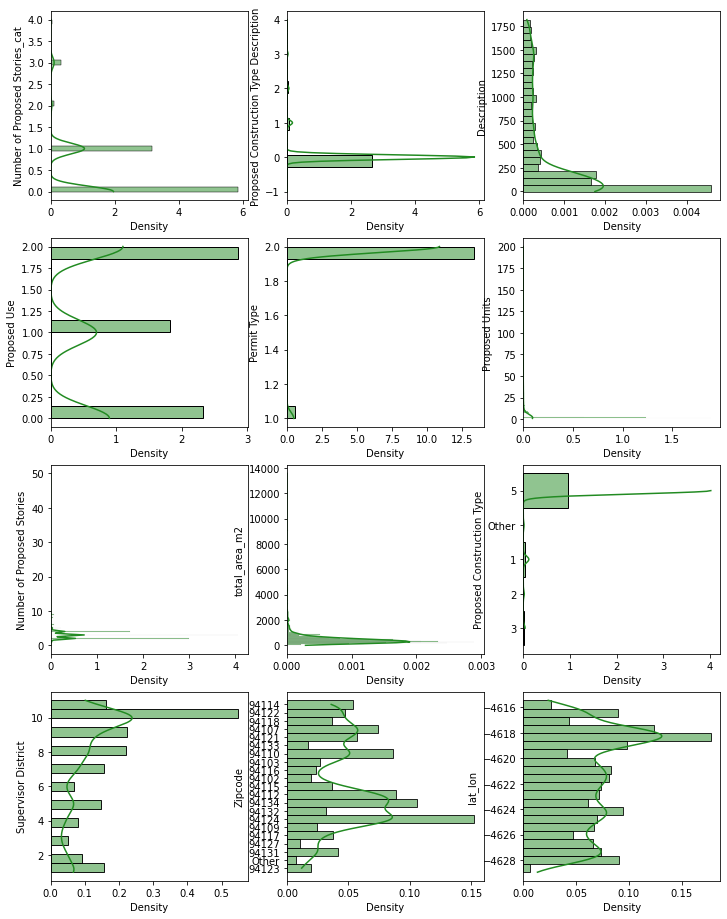

In [35]:
#newdf=newdf.sample(1000)#frac=0.01)#0.15)

fig, axes = plt.subplots(nrows = 4, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(12, 16)

for ax, col in zip(axes, newdf.columns):
    sns.histplot(data=newdf,y=col,kde=True,ax=ax,stat='density',color='forestgreen')


***Let's check the skewedness of the distribution***

Since we observe

    Deviation from the normal distribution.
    positive skewness.
    peakedness.


*We will use the version 4 of database to explain how we chosed the outliers to create v8 of database.*

**⬛ Identifying outliers in target column by using history and normal probability plot**

In [36]:
from scipy.stats import norm
from scipy import stats
import seaborn as sns

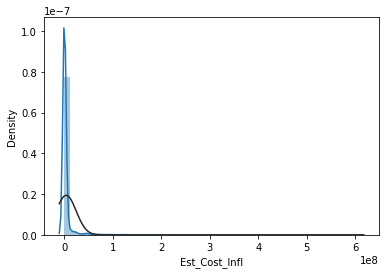

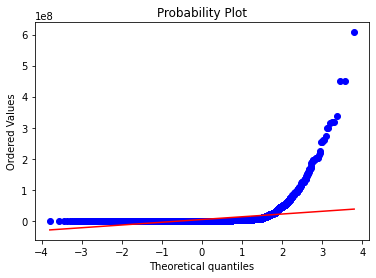

In [37]:
#histogram and normal probability plot
sns.distplot(dataset['Est_Cost_Infl'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset['Est_Cost_Infl'], plot=plt)

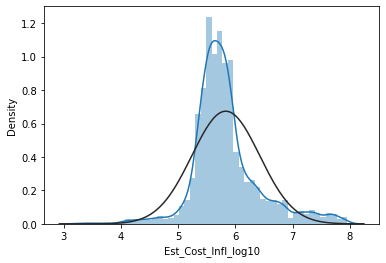

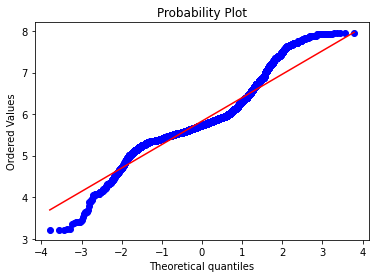

In [38]:
# log transformation of Est Cost
m_out0 = dataset['Est_Cost_Infl_log10'] < dataset['Est_Cost_Infl_log10'].quantile(.99)
m_out1 = dataset['Est_Cost_Infl_log10'] > dataset['Est_Cost_Infl_log10'].quantile(.01)

m_out = m_out0 & m_out1
#histogram and normal probability plot
sns.distplot(dataset['Est_Cost_Infl_log10'][m_out], fit=norm)
fig = plt.figure()

#note that probplot calculates quantiles for a probability plot, and shows the plot.
res = stats.probplot(dataset['Est_Cost_Infl_log10'][m_out], plot=plt)

*** Conclusion ***

We take central 98% of estimated cost data.

Log10 transformation of estimated cost results in more 'normal-distrubution' looking data so it is better.

We will also check the relationship of other variables.

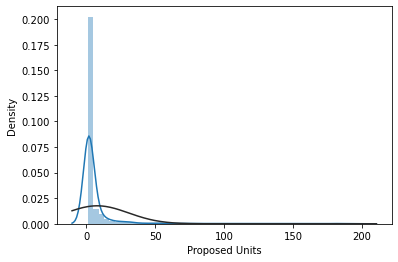

In [39]:
# log transformation of Est Cost
m_out2 = dataset['Proposed Units'] < dataset['Proposed Units'].quantile(.99)
m_out3 = dataset['Proposed Units'] > dataset['Proposed Units'].quantile(.01)
m_out = m_out0 & m_out1 & m_out2 & m_out3

#histogram and normal probability plot
vals = dataset['Proposed Units'][m_out]
sns.distplot(vals, fit=norm)

***Check outliers***



*   Within 'Proposed Units', there are few data (<1%) with 0 units!
*   Within 'Proposed Units', there are few data (<1%) above 150 units!

Let's eliminate these possible particular cases/outliers.



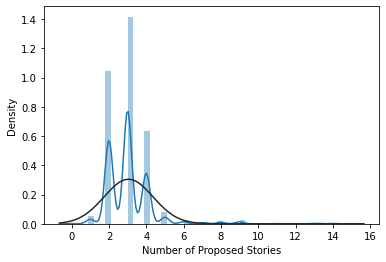

In [40]:
m_out4 = dataset['Number of Proposed Stories'] <= 15
m_out = m_out0 & m_out1 & m_out2 & m_out3 & m_out4

#histogram and normal probability plot
vals = dataset['Number of Proposed Stories'][m_out]
sns.distplot(vals, fit=norm)

*** Discussions***


*   Let's take dataset['Number of Proposed Stories'] < 15. We will limit our prediction capability up to 15 stories.

#Skewed features


**Let's see the skewedness of these columns**

We will use skewedness of data distributions to apply boxcox1p transformation. 

We use the scipy function boxcox1p which computes the Box-Cox transformation of 1+x. 

Note that setting λ=0 is equivalent to log1p used above for the target variable.

ref, https://medium.com/@kangeugine/box-cox-transformation-ba01df7da884

In [42]:
#explain this part further
from scipy import stats
from scipy.stats import norm, skew 

In [43]:
numeric_feats = newdf.dtypes[newdf.dtypes != "object"].index
newdf_bct = newdf.loc[m_out,:]
# Check the skew of all numerical features
skewed_feats = newdf_bct[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



Skew
Number of Proposed Stories              9.364949
total_area_m2                           8.852962
Proposed Construction Type Description  6.216290
Proposed Units                          5.947983
Number of Proposed Stories_cat          2.020197
Description                             1.140932
Proposed Use                           -0.131859
lat_lon                                -0.183705
Supervisor District                    -0.817348
Permit Type                            -4.395131

In [44]:
skewness = skewness[abs(skewness) > 2.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.10
for feat in skewness.index:
    newdf_bct[feat+'_bct'] = boxcox1p(newdf[feat], lam)
    

There are 10 skewed numerical features to Box Cox transform


**Let's check out the skewedness after boxcox1p transformation:**

In [45]:
numeric_feats = newdf_bct.dtypes[newdf_bct.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = newdf_bct[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



Skew
Number of Proposed Stories                   9.364949
total_area_m2                                8.852962
Proposed Construction Type Description       6.216290
Proposed Units                               5.947983
Proposed Units_bct                           2.455034
Number of Proposed Stories_cat               2.020197
Number of Proposed Stories_bct               1.312166
Description                                  1.140932
Number of Proposed Stories_cat_bct           1.128280
total_area_m2_bct                            0.868247
Proposed Use                                -0.131859
lat_lon                                     -0.183705
Proposed Use_bct                            -0.342288
Supervisor District                         -0.817348
Supervisor District_bct                     -1.381140
Description_bct                             -1.510488
Permit Type_bct                             -4.395131
Permit Type                                 -4.395131
Proposed Construction Type Description_bct -17.647069
lat_lon_bct                                       NaN

**Discussion**

After trial and error with machine learning models, we observed that boxcox1p transformation improves the scores of linear regressor model (and lasso). The scores remain same for the boosting algorithms and random forest tree.

=> As we use boosting algorithms or random forest algorithm in our final product, we don't need the boxcox1p transformations. 


**Conclusion**

Finally, we apply the following masks on the original database from SFdata.gov:

* permit_type_mask = dataset["Permit Type"] < 3

* permit_complete_mask = dataset["Current Status"] == "complete"

* m_pu1 = dataset["Proposed Use"]=="1 family dwelling"

*  m_pu2 = dataset["Proposed Use"]=="2 family dwelling"
  
*  m_pu3 = dataset["Proposed Use"]=="apartments"
  
* m_out0 = dataset['Est_Cost_Infl_log10'] <= dataset['Est_Cost_Infl_log10'].quantile(0.99)
* m_out1 = dataset['Est_Cost_Infl_log10'] >= dataset['Est_Cost_Infl_log10'].quantile(0.01)
* m_out2 = dataset['Proposed Units'] <= dataset['Proposed Units'].quantile(0.99)
* m_out3 = dataset['Proposed Units'] > dataset['Proposed Units'].quantile(0.01)
* m_out4 = dataset['Number of Proposed Stories_'] <= 15

**Outliers on map**

In [46]:
print('Here is a map of identified outliers or particular cases in the database:')
lat0 , lon0 = 37.750000, -122.431000

dataset_ =  dataset.loc[~m_out,:]#.dropna(subset=['Number of Proposed Stories', 'Proposed Units'])
fig = px.scatter_mapbox(dataset_.loc[:1566,:], lat="lon", lon="lat",
                        zoom = 11.0, center = {'lat': lat0, 'lon': lon0}, 
                        mapbox_style="stamen-toner",#"carto-positron", #color='Total counts',
                        color= 'Estimated cost in today s dollars in log10',#size_max = 70,
                        title = 'Identified outliers or particular cases',
                        hover_name = 'address',
                        hover_data = {#'Total counts': True,
                                      'Number of Proposed Stories':True,
                                      'Proposed Units':True,
                                      'Completed Year':True,
                                      'Description':True,
                                      'Proposed Use' : True,
                                      'Cost_1M':True,
                                      'Estimated cost in today s dollars in log10':False,
                                      'lon' : False,
                                      'lat' : False,
                                      }                     
)

fig.update_layout( hovermode="closest")
fig.show()

Here is a map of identified outliers or particular cases in the database:
